# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [7]:
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize
sns.set()
import gc #garbage collector
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\caper\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
%%time
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

Wall time: 0 ns


### Reviews: Filtro de registros del dataset original

Voy a ir por otro camino diferente al remcomendado por el código inicial del notebook.
Considero una mejor opción a elegir estratégicamente los registros que voy a utilizar para el sistema de recomendación, de acuerdo a la cantidad de juegos criticados/jugados por los usuarios. Voy a tratar de encontrar un balance entre:
* **La cantidad de registros.** Para no sobrecargar la memoria RAM de mi equipo.
* **La cantidad de usuarios.** Para tener suficiente diversidad de gustos y críticas de juegos.
* **La cantidad de juegos criticados por usuario.** Descartando usuarios que hayan jugado solamente 1 juego, que no aportan demasiado al sistema de recomendación y también usuarios que hayan jugado más de 50 juegos, para bajar la cantidad de registros que uso por usuario, y poder tener mayor cantidad de criticas de diferentes usuarios en el dataset.


In [3]:
%%time
contador = 0
data_reviews = []
# Vamos a guardar una de cada todos los reviews. Si pones n = 3, abrira uno de cada tres, y asi.
n = 1
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


Wall time: 4min 41s


In [4]:
%%time
data_reviews = pd.DataFrame(data_reviews)

Wall time: 21.6 s


Me quedo con solo con los registros escritos por usuarios que jugaron al menos 3 juegos:

In [6]:
%%time
mask = data_reviews["username"].value_counts() >= 3
trues =  mask.where(mask == True).dropna()
lista = list(trues.index)

Wall time: 5.42 s


In [7]:
%%time
data_reviews_I =  data_reviews[data_reviews["username"].isin(lista)]
data_reviews_I

Wall time: 3.93 s


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075
5,Teef 🐏,0.9,923.0,725280,1,2017-12-03,hey thanks for stealing my spritework,False,1,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7793062,Don Camillo,261.7,298.0,252490,3,2013-12-11,its so meganice this game Big Thanks To Garry ...,True,10221,NaN,NaN,76561197983773018
7793063,Corvo,157.8,29.0,252490,4,2013-12-11,"Great multi-player survival game, iv'e been p...",True,10221,NaN,NaN,NaN
7793065,Stony,1215.2,73.0,252490,6,2013-12-11,really fun and addictive game to play,True,10221,NaN,NaN,76561198089897928
7793067,Vidaar,783.5,353.0,252490,8,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10221,NaN,NaN,NaN


Es un dataset demasiado grande, voy a quedarme solo con las primeras 1.500.000 instancias.

In [8]:
%%time
data_reviews_II = data_reviews_I.head(1500000)
data_reviews_II

Wall time: 998 µs


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075
5,Teef 🐏,0.9,923.0,725280,1,2017-12-03,hey thanks for stealing my spritework,False,1,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2163340,mojo_tas,55.7,77.0,289650,7,2015-01-03,The return to familiar game mechanics (far mor...,False,364,NaN,NaN,76561198014273563
2163341,RDZ,12.5,152.0,207610,1,2015-07-26,11/10 Would cry again.,False,851,NaN,NaN,NaN
2163342,Ex Nihiloish,8.3,254.0,262060,3,2017-09-20,Super fun for the masochists.,False,252,NaN,NaN,NaN
2163346,Đuииø ʕ ·ᴥ·ʔ,136.9,81.0,211820,0,2014-12-18,winter is coming update so cool to play this g...,True,2540,NaN,NaN,NaN


Controlo si en las instancias que filtré hay usuarios con solamente un videojuego jugado:

No handles with labels found to put in legend.


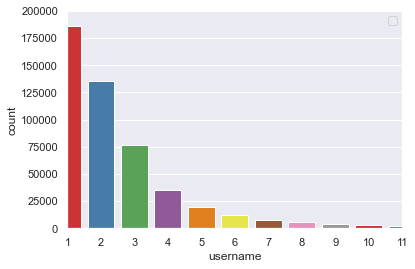

In [9]:
sns.countplot(x= data_reviews_II["username"].value_counts(), data=data_reviews_II, palette="Set1")
plt.ylim(0,200000)
plt.xlim(0,10)
plt.legend()

In [10]:
data_reviews_II["username"].value_counts().describe()

count    500439.000000
mean          2.997368
std           5.517527
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         483.000000
Name: username, dtype: float64

Descarto las instancias con menos de 2 y más de 50 videojuegos jugados, sobre el filtro que ya hice:

In [11]:
%%time
mask = (data_reviews_II["username"].value_counts() >= 2) & (data_reviews_II["username"].value_counts() <= 50)
trues =  mask.where(mask == True).dropna()
lista = list(trues.index)

Wall time: 1.87 s


In [12]:
%%time
data_reviews_III =  data_reviews_II[data_reviews_II["username"].isin(lista)]
data_reviews_III

Wall time: 611 ms


,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075
5,Teef 🐏,0.9,923.0,725280,1,2017-12-03,hey thanks for stealing my spritework,False,1,1.0,NaN,NaN
7,Sneaky_Panda,0.6,243.0,725280,3,2017-11-27,If you take a discount - it's not a bad horror...,False,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2163333,TrickyDicky,20.4,237.0,289650,6,2015-01-03,Pros\nGreat Graphics\nGameplay is fun\nParis l...,False,364,NaN,NaN,NaN
2163335,probe,58.4,94.0,262060,2,2017-09-21,I'm so bad at this game but I really like it. ...,False,252,NaN,NaN,76561198093203804
2163341,RDZ,12.5,152.0,207610,1,2015-07-26,11/10 Would cry again.,False,851,NaN,NaN,NaN
2163342,Ex Nihiloish,8.3,254.0,262060,3,2017-09-20,Super fun for the masochists.,False,252,NaN,NaN,NaN


No handles with labels found to put in legend.


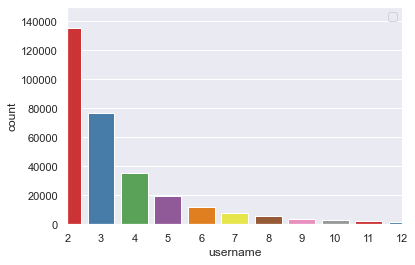

In [14]:
sns.countplot(x= data_reviews_III["username"].value_counts(), data=data_reviews_III, palette="Set1")
plt.ylim(0,150000)
plt.xlim(0,10)
plt.legend()

In [23]:
data_reviews_III["username"].value_counts().describe()

count    313264.000000
mean          3.931518
std           3.924515
min           2.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          50.000000
Name: username, dtype: float64

Caracterísitcas del dataset inicial:

In [28]:
print("Cantidad de registros:", data_reviews_III.shape[0])
print("Cantidad de usuarios:", data_reviews_III["username"].value_counts().shape[0])
print("Cantidad de mínima de videojuegos jugados por usuario:", data_reviews_III["username"].value_counts().min())
print("Cantidad de máxima de videojuegos jugados por usuario:", data_reviews_III["username"].value_counts().max())
print("Promedio de videojuegos jugados por usuario:", data_reviews_III["username"].value_counts().mean())

Cantidad de registros: 1231603
Cantidad de usuarios: 313264
Cantidad de mínima de videojuegos jugados por usuario: 2
Cantidad de máxima de videojuegos jugados por usuario: 50
Promedio de videojuegos jugados por usuario: 3.9315178252209


Descarto la información que no voy a usar de dataset:

In [29]:
steam_reviews_I =  data_reviews_III.drop(["products", "user_id", "compensation", "found_funny", "page", "early_access", "date", "page_order"], axis=1)
steam_reviews_I.head()

,username,hours,product_id,text
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,looks like a facebook game
3,Cyderine916,5.0,35140,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,Still worth playing in 2018.\nProbably my favo...
5,Teef 🐏,0.9,725280,hey thanks for stealing my spritework
7,Sneaky_Panda,0.6,725280,If you take a discount - it's not a bad horror...


Investigo y descarto los valores faltantes restantes:

In [30]:
steam_reviews_I.isna().sum().to_frame()

,0
username,0
hours,6663
product_id,0
text,0


In [31]:
steam_reviews_I.dropna(inplace=True)

In [32]:
steam_reviews_I.isna().sum().to_frame()

,0
username,0
hours,0
product_id,0
text,0


In [33]:
steam_reviews_I

,username,hours,product_id,text
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,looks like a facebook game
3,Cyderine916,5.0,35140,I love and idolized Batman and this game is Ma...
4,DarklyThinking,16.6,35140,Still worth playing in 2018.\nProbably my favo...
5,Teef 🐏,0.9,725280,hey thanks for stealing my spritework
7,Sneaky_Panda,0.6,725280,If you take a discount - it's not a bad horror...
...,...,...,...,...
2163333,TrickyDicky,20.4,289650,Pros\nGreat Graphics\nGameplay is fun\nParis l...
2163335,probe,58.4,262060,I'm so bad at this game but I really like it. ...
2163341,RDZ,12.5,207610,11/10 Would cry again.
2163342,Ex Nihiloish,8.3,262060,Super fun for the masochists.


Guardo en un CSV el primer Checkpoint del dataframe. Éste incluye:
* El filtrado aplicado al dataset original de Steam 
* La eliminación de las columnas inútiles
* El descarte de los 6663 datos faltantes en la columna ***hours*** 


Me quedan 1224940 registros para seguir trabajando.

In [34]:
steam_reviews_I.to_csv('steam_reviews_I.csv', index= False)

In [56]:
steam_reviews_I = pd.read_csv('steam_reviews_I.csv')

## 1. Métrica por sentimientos de reviews

### a. Detectar el idioma de las reviews

Para armar un sistema de recomendaciones necesito armar una métrica que logre estimar una calificación de parte de cada usuario, para cada review.  
Mi idea es armar ésta métrica como una combinación de un analisis de sentimientos de los reviews y de la horas jugadas a la hora del review.

Primero voy a enfocarme en el análisis de sentimientos. Para ésto necesito comprobar que tengo todas o la mayoría de las reviews en en el mismo idioma.

Voy a crear una función con la librería ***nltk*** que detecte el idioma de un string de datos:

In [38]:
def detect_language(x):
    languages = ["spanish","english","dutch","finnish","german","italian","portuguese","turkish","danish","french","hungarian","norwegian","russian","swedish"]
    tokens = nltk.tokenize.word_tokenize(x)
    tokens = [t.strip().lower() for t in tokens]
    lang_count = {}
    for lang in languages:
        stop_words = nltk.corpus.stopwords.words(lang)
        lang_count[lang] = 0
        for word in tokens:
            if word in stop_words:
                lang_count[lang] += 1
    detected_language = max(lang_count, key=lang_count.get)
    return detected_language

Prueba de la función:

In [39]:
print("review: ",steam_reviews_I["text"][2],"\n idioma: ", detect_language(steam_reviews_I["text"][2]))

review:  Still worth playing in 2018.
Probably my favorite batman game overall.
It lacks the open world aspect of its sequels but makes up for it with a condensed and tense story.
Getting 100% of the trophies also didn't feel like a chore(which must be a first for me). 
 idioma:  english


Dado que pudimos comprobar que funciona la función creada, antes de aplicarla a cada review, voy a crear otra columna en el dataframe que pase a formato string todas las reviews y ademas las deje en letra minúscula. Esto va a evitar errores y va a servirme a futuro para el análisis de sentimientos:

In [40]:
%%time
steam_reviews_I['str_review'] = steam_reviews_I.apply(lambda row: str(row.text).lower(), axis=1)

Wall time: 13.5 s
Compiler : 252 ms


In [41]:
steam_reviews_I

,username,hours,product_id,text,str_review
0,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,looks like a facebook game,looks like a facebook game
1,Cyderine916,5.0,35140,I love and idolized Batman and this game is Ma...,i love and idolized batman and this game is ma...
2,DarklyThinking,16.6,35140,Still worth playing in 2018.\nProbably my favo...,still worth playing in 2018.\nprobably my favo...
3,Teef 🐏,0.9,725280,hey thanks for stealing my spritework,hey thanks for stealing my spritework
4,Sneaky_Panda,0.6,725280,If you take a discount - it's not a bad horror...,if you take a discount - it's not a bad horror...
...,...,...,...,...,...
1224935,TrickyDicky,20.4,289650,Pros\nGreat Graphics\nGameplay is fun\nParis l...,pros\ngreat graphics\ngameplay is fun\nparis l...
1224936,probe,58.4,262060,I'm so bad at this game but I really like it. ...,i'm so bad at this game but i really like it. ...
1224937,RDZ,12.5,207610,11/10 Would cry again.,11/10 would cry again.
1224938,Ex Nihiloish,8.3,262060,Super fun for the masochists.,super fun for the masochists.


Una vez realizado creada la columna totalmente en string, aplico la función ***detect_language*** a todas las reviews:

In [42]:
%%time
reviews_list = steam_reviews_I['str_review']
lg_review=[]
for review in reviews_list:
    lg_review.append(detect_language(review))

Wall time: 1h 50min 48s


In [43]:
steam_reviews_I['lg_review'] = lg_review
steam_reviews_I

,username,hours,product_id,text,str_review,lg_review
0,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,looks like a facebook game,looks like a facebook game,spanish
1,Cyderine916,5.0,35140,I love and idolized Batman and this game is Ma...,i love and idolized batman and this game is ma...,english
2,DarklyThinking,16.6,35140,Still worth playing in 2018.\nProbably my favo...,still worth playing in 2018.\nprobably my favo...,english
3,Teef 🐏,0.9,725280,hey thanks for stealing my spritework,hey thanks for stealing my spritework,english
4,Sneaky_Panda,0.6,725280,If you take a discount - it's not a bad horror...,if you take a discount - it's not a bad horror...,english
...,...,...,...,...,...,...
1224935,TrickyDicky,20.4,289650,Pros\nGreat Graphics\nGameplay is fun\nParis l...,pros\ngreat graphics\ngameplay is fun\nparis l...,english
1224936,probe,58.4,262060,I'm so bad at this game but I really like it. ...,i'm so bad at this game but i really like it. ...,english
1224937,RDZ,12.5,207610,11/10 Would cry again.,11/10 would cry again.,english
1224938,Ex Nihiloish,8.3,262060,Super fun for the masochists.,super fun for the masochists.,english


In [44]:
steam_reviews_I.lg_review.value_counts().to_frame()

,lg_review
english,1095097
spanish,121687
german,1464
russian,1410
dutch,1151
portuguese,1044
danish,822
italian,784
french,611
hungarian,345


Estudiando un poco el dataset descubrí que gran parte de los reviews clasificados en español están en realidad en inglés: 

In [45]:
steam_reviews_I[steam_reviews_I.lg_review == "spanish"].head(15)

,username,hours,product_id,text,str_review,lg_review
0,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,looks like a facebook game,looks like a facebook game,spanish
11,Duha Nubie,11.3,35140,first debut feel sweet,first debut feel sweet,spanish
12,Jordan!,0.3,671270,Get a hat onto Uncle Moneybags.,get a hat onto uncle moneybags.,spanish
14,Weaky1100,1.3,350280,BADASS,badass,spanish
18,Kaelandros,1.5,328100,me likey likey,me likey likey,spanish
33,Zyphrus,12.3,288690,Nice little sudoku game.,nice little sudoku game.,spanish
58,Duncan,163.9,365560,Nice simple game. Old school area movement boa...,nice simple game. old school area movement boa...,spanish
63,Dew,0.2,288690,ужас,ужас,spanish
64,BARACK OBAMA,1.2,8880,Underrated classic,underrated classic,spanish
70,youarenxt1,12.3,350280,good........,good........,spanish


Para intentar solucionarlo voy a aplicar el siguiente ***np.select***.
Este va a a buscar ciertas palabras en inglés que se repiten en las reviews clasificadas cómo español, y si las encuentra en esa review, va a reclasificarla en inglés.

In [46]:
%%time
steam_reviews_I.str_review = steam_reviews_I.str_review.str.lower()

conditions1 = [
    (steam_reviews_I['str_review'].str.contains("great", na=False)),
    (steam_reviews_I['str_review'].str.contains("game", na=False)),
    (steam_reviews_I['str_review'].str.contains("nice", na=False)),
    (steam_reviews_I['str_review'].str.contains("extremely", na=False)),
    (steam_reviews_I['str_review'].str.contains("good", na=False)),
    (steam_reviews_I['str_review'].str.contains("best", na=False)),
    (steam_reviews_I['str_review'].str.contains("complicated", na=False)),
    (steam_reviews_I['str_review'].str.contains("away", na=False)),
    (steam_reviews_I['str_review'].str.contains("dead", na=False)),
    (steam_reviews_I['str_review'].str.contains("yes", na=False)),
    (steam_reviews_I['str_review'].str.contains("yeah", na=False)),
    (steam_reviews_I['str_review'].str.contains("help", na=False)),
    (steam_reviews_I['str_review'].str.contains("garbage", na=False)),
    (steam_reviews_I['str_review'].str.contains("awesome", na=False)),
    (steam_reviews_I['str_review'].str.contains("awsome", na=False)),
    (steam_reviews_I['str_review'].str.contains("perfect", na=False)),
    (steam_reviews_I['str_review'].str.contains("cool", na=False)),
    (steam_reviews_I['str_review'].str.contains("again", na=False)),
    (steam_reviews_I['str_review'].str.contains("amazing", na=False)),
    (steam_reviews_I['str_review'].str.contains("boring", na=False)),
    (steam_reviews_I['str_review'].str.contains("masterpiece", na=False)),
    (steam_reviews_I['str_review'].str.contains("addict", na=False)),
    (steam_reviews_I['str_review'].str.contains("recommend", na=False)),
    (steam_reviews_I['str_review'].str.contains("really", na=False)),
    (steam_reviews_I['str_review'].str.contains("sweet", na=False)),
    (steam_reviews_I['str_review'].str.contains("hacker", na=False))
    ]

values1 = ["english", "english", "english", "english", "english", "english","english", "english", "english", "english", "english", "english", "english", "english", "english", "english","english", "english", "english", "english", "english", "english", "english", "english", "english", "english"]

steam_reviews_I['lg_review'] = np.select(conditions1, values1, default = steam_reviews_I['lg_review'])

Wall time: 27.1 s
Compiler : 231 ms
Parser   : 115 ms


Nueva distribución de idiomas para los reviews:

In [47]:
steam_reviews_I.lg_review.value_counts().to_frame()

,lg_review
english,1148128
spanish,70427
russian,1363
german,1014
dutch,892
portuguese,803
italian,603
danish,521
french,500
hungarian,252


In [48]:
steam_reviews_I = steam_reviews_I[steam_reviews_I["lg_review"] == "english"]
steam_reviews_I.lg_review.value_counts().to_frame()

,lg_review
english,1148128


Guardo en un CSV el segundo Checkpoint del dataframe. Éste incluye:
* Una nueva columna str_review, que es el resultado de transformar todos los registros de la columna ***text*** en string y en minúscula.  
* Una nueva columna lg_review, en la que figura el idioma en el que fue escrito la review.
* El descarte 51260 registros en otros idiomas distintos del inglés. 

Me quedan 1148128 registros para seguir trabajando.

In [49]:
steam_reviews_I.to_csv('steam_reviews_II.csv', index= False)
steam_reviews_II = pd.read_csv('steam_reviews_II.csv')

### b. Análisis de sentimientos de las reviews

Armé una función para analizar los sentimientos de un string.
Funciona de ésta manera:
1. Necesita un string como parámetro.
1. Arma con cada una de las palabras del string, una lista.
1. En la lista de palabras revisa que no haya stopwords para el idioma ingles, y si encuentra las descarta.
1. Vuelvo a transformar la lista en un string concatenado con espacios entre cada palabra.
1. Aplico el analizador de sentimientos ***SentimentIntensityAnalyzer*** de la librería ***nltk***.
1. La función evuelve el score ***compund*** resultante del analisis de sentimientos. Toma valores entre -1 y 1. Cuanto más cerca de 1, más positiva será la review del usuario, y cuanto más cerca de -1, más negativa.

In [50]:
stopwords = nltk.corpus.stopwords.words("english")

In [51]:
def Sentiment_Analyzer(x):
    tokens = nltk.tokenize.word_tokenize(x)
    tokens_wsw = [w for w in tokens if w.lower() not in stopwords]
    analizador = SentimentIntensityAnalyzer()
    sent_str = ""
    for i in tokens_wsw:
        sent_str += str(i) + " "
    tokens_final = sent_str[:-1]
    scores = analizador.polarity_scores(tokens_final)
    return scores['compound']

Aplico la función a mi dataset:

In [52]:
%%time
review_sent_list=[]
for i in range(steam_reviews_II.shape[0]):
    review = steam_reviews_II.iloc[i].str_review
    review_sent_list.append(Sentiment_Analyzer(review))

Wall time: 2h 26min 49s
Parser   : 352 ms


In [53]:
steam_reviews_II['sentiment_review'] = review_sent_list

In [54]:
%%time
scaler = MinMaxScaler()
steam_reviews_Scal = steam_reviews_II.copy()
steam_reviews_Scal = scaler.fit_transform(steam_reviews_Scal[["sentiment_review"]])
steam_reviews_II["sentiment_review"] = steam_reviews_Scal
steam_reviews_II["sentiment_review"].describe()

Wall time: 1.31 s


count    1.148128e+06
mean     7.215126e-01
std      2.724572e-01
min      0.000000e+00
25%      5.000000e-01
50%      8.184500e-01
75%      9.455000e-01
max      1.000000e+00
Name: sentiment_review, dtype: float64

In [55]:
steam_reviews_II

,username,hours,product_id,text,str_review,lg_review,sentiment_review
0,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,looks like a facebook game,looks like a facebook game,english,0.68060
1,Cyderine916,5.0,35140,I love and idolized Batman and this game is Ma...,i love and idolized batman and this game is ma...,english,0.92595
2,DarklyThinking,16.6,35140,Still worth playing in 2018.\nProbably my favo...,still worth playing in 2018.\nprobably my favo...,english,0.64685
3,Teef 🐏,0.9,725280,hey thanks for stealing my spritework,hey thanks for stealing my spritework,english,0.39885
4,Sneaky_Panda,0.6,725280,If you take a discount - it's not a bad horror...,if you take a discount - it's not a bad horror...,english,0.09900
...,...,...,...,...,...,...,...
1148123,TrickyDicky,20.4,289650,Pros\nGreat Graphics\nGameplay is fun\nParis l...,pros\ngreat graphics\ngameplay is fun\nparis l...,english,0.99155
1148124,probe,58.4,262060,I'm so bad at this game but I really like it. ...,i'm so bad at this game but i really like it. ...,english,0.58270
1148125,RDZ,12.5,207610,11/10 Would cry again.,11/10 would cry again.,english,0.26165
1148126,Ex Nihiloish,8.3,262060,Super fun for the masochists.,super fun for the masochists.,english,0.85920


Lograda la primer métrica para evaluar los reviews: ***sentiment_review***. Toma valores entre 0 y 1, cuando más negativa es la review, más cercana a cero es la métrica, y cuánto mas positiva es, más cercana a uno.
    
Voy a guardar en un CSV el tercer Checkpoint del dataframe. Éste incluye:
* Una nueva columna ***sentiment_review***, la primer métrica para evaluar los reviews de los usuarios.

Me quedan 723804 registros para seguir trabajando.

In [56]:
steam_reviews_II.to_csv('steam_reviews_III.csv', index= False)

In [115]:
steam_reviews_III = pd.read_csv('steam_reviews_III.csv')

## 2. Métrica por cantidad de horas jugadas

### a. Tratamiento de valores atípicos

Primero vamos a analizar y tratar los valores atípicos:

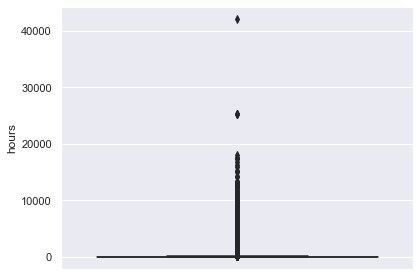

In [117]:
sns.boxplot(data = steam_reviews_III, y = "hours", color = "purple")
plt.tight_layout()
plt.show()

In [118]:
steam_reviews_III.hours.describe()

count    1.148128e+06
mean     7.762841e+01
std      2.843521e+02
min      0.000000e+00
25%      3.700000e+00
50%      1.370000e+01
75%      4.750000e+01
max      4.210070e+04
Name: hours, dtype: float64

In [119]:
np.percentile(steam_reviews_III.hours, 97)

506.3189999999944

Voy a remplzar todos los registros donde la cantidad de horas jugadas sean superiores al percentil 97 (de esa variable), por el percetil 97 (506.31).

In [120]:
a = np.array(steam_reviews_III['hours'].values.tolist())
steam_reviews_III['hours'] = np.where(a > 506.31, 506.31, a).tolist()
print(steam_reviews_III.hours.describe())

count    1.148128e+06
mean     5.693817e+01
std      1.099578e+02
min      0.000000e+00
25%      3.700000e+00
50%      1.370000e+01
75%      4.750000e+01
max      5.063100e+02
Name: hours, dtype: float64


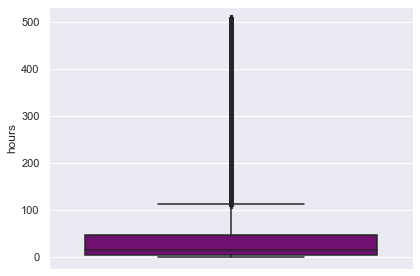

In [121]:
sns.boxplot(data = steam_reviews_III, y = "hours", color = "purple")
plt.tight_layout()
plt.show()

Voy a revisar que no haya registros con horas jugadas iguales a cero:

In [123]:
steam_reviews_III[steam_reviews_III.hours == 0]

,username,hours,product_id,text,str_review,lg_review,sentiment_review
2345,DarkEvil,0.0,8880,This is a bit old and the controls will someti...,this is a bit old and the controls will someti...,english,0.91125
2427,Neemulus,0.0,8790,"even today (Oct 2013), I still think this is o...","even today (oct 2013), i still think this is o...",english,0.50000
5361,Sophie,0.0,341720,I like it ：）,i like it ：）,english,0.68060
7382,The Chairman,0.0,26900,"Gorgeous music, cute graphics and addicting ga...","gorgeous music, cute graphics and addicting ga...",english,0.89530
7705,theshadowscythe,0.0,7650,"Xcom, but with added cthulu.\nEnjoy.","xcom, but with added cthulu.\nenjoy.",english,0.74695
...,...,...,...,...,...,...,...
1139803,jimbobforrest,0.0,285160,it says it works on mack but it doesnt im abso...,it says it works on mack but it doesnt im abso...,english,0.74865
1141822,Onemario1234,0.0,302830,you have to pay to unlock weapons. but besides...,you have to pay to unlock weapons. but besides...,english,0.78480
1142475,butthole,0.0,302830,10 corn dogs/13 chicken nuggets best uninstall...,10 corn dogs/13 chicken nuggets best uninstall...,english,0.81845
1142626,Blacksept69,0.0,207610,The Feels deeaaarrr god the ffffeeeeeeeeeellll...,the feels deeaaarrr god the ffffeeeeeeeeeellll...,english,0.75265


In [124]:
steam_reviews_III = steam_reviews_III[(steam_reviews_III.hours > 0)]
steam_reviews_III[steam_reviews_III.hours == 0]

,username,hours,product_id,text,str_review,lg_review,sentiment_review


Ya tengo la segunda métrica para el sistema de recomendación: ***hours***. 

Voy a guardar en un CSV el cuarto Checkpoint del dataframe. Éste incluye:
* Análisis y tratamiento de atípicos a la columna ***hours***.
* Descarte los registros con cero horas jugadas

In [125]:
steam_reviews_III.to_csv('steam_reviews_IV.csv', index= False)

In [126]:
steam_reviews_IV = pd.read_csv('steam_reviews_IV.csv')

Voy a controlar que no queden registros de usuarios con menos de 2 videojuegos jugados:

No handles with labels found to put in legend.


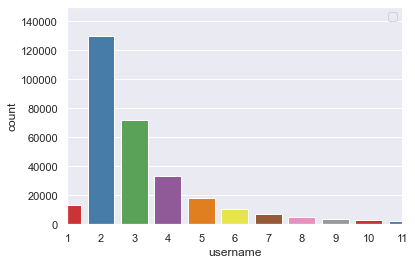

In [127]:
sns.countplot(x= steam_reviews_IV["username"].value_counts(), data=steam_reviews_IV, palette="Set1")
plt.ylim(0,150000)
plt.xlim(0,10)
plt.legend()

In [128]:
steam_reviews_IV["username"].value_counts().describe()

count    307682.000000
mean          3.729614
std           3.716535
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          50.000000
Name: username, dtype: float64

Se apuede apreciar en las celdas anteriores que quedan registros con usuarios con solo 1 juego jugado. Voy a proceder a descartar esas instancias:

In [129]:
%%time
mask = (steam_reviews_IV["username"].value_counts() >= 2)
trues =  mask.where(mask == True).dropna()
lista = list(trues.index)

Wall time: 526 ms


In [130]:
%%time
steam_reviews_V =  steam_reviews_IV[steam_reviews_IV["username"].isin(lista)]
steam_reviews_V

Wall time: 551 ms


,username,hours,product_id,text,str_review,lg_review,sentiment_review
0,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,328100,looks like a facebook game,looks like a facebook game,english,0.68060
1,Cyderine916,5.0,35140,I love and idolized Batman and this game is Ma...,i love and idolized batman and this game is ma...,english,0.92595
2,DarklyThinking,16.6,35140,Still worth playing in 2018.\nProbably my favo...,still worth playing in 2018.\nprobably my favo...,english,0.64685
3,Teef 🐏,0.9,725280,hey thanks for stealing my spritework,hey thanks for stealing my spritework,english,0.39885
4,Sneaky_Panda,0.6,725280,If you take a discount - it's not a bad horror...,if you take a discount - it's not a bad horror...,english,0.09900
...,...,...,...,...,...,...,...
1147587,TrickyDicky,20.4,289650,Pros\nGreat Graphics\nGameplay is fun\nParis l...,pros\ngreat graphics\ngameplay is fun\nparis l...,english,0.99155
1147588,probe,58.4,262060,I'm so bad at this game but I really like it. ...,i'm so bad at this game but i really like it. ...,english,0.58270
1147589,RDZ,12.5,207610,11/10 Would cry again.,11/10 would cry again.,english,0.26165
1147590,Ex Nihiloish,8.3,262060,Super fun for the masochists.,super fun for the masochists.,english,0.85920


Caracterísiticas del dataset final:

### Otras métricas analizadas:

In [17]:
print("Cantidad de registros:", steam_reviews_V.shape[0])
print("Cantidad de usuarios:", steam_reviews_V["username"].value_counts().shape[0])
print("Cantidad de mínima de videojuegos jugados por usuario:", steam_reviews_V["username"].value_counts().min())
print("Cantidad de máxima de videojuegos jugados por usuario:", steam_reviews_V["username"].value_counts().max())
print("Promedio de videojuegos jugados por usuario:", steam_reviews_V["username"].value_counts().mean())
print("Promedio de horas jugadas:", steam_reviews_V["hours"].mean())

Cantidad de registros: 1134141
Cantidad de usuarios: 294288
Cantidad de mínima de videojuegos jugados por usuario: 2
Cantidad de máxima de videojuegos jugados por usuario: 50
Promedio de videojuegos jugados por usuario: 3.853847251671832
Promedio de horas jugadas: 57.024737753065985


Este es el dataset que al que voy a volver en caso que la métrica seleccionada para la calificación no tenga buenos resultados.

In [132]:
steam_reviews_V.to_csv('steam_reviews_V.csv', index= False)

In [10]:
steam_reviews_V = pd.read_csv('steam_reviews_V.csv')

## 3. Métrica Score

In [18]:
steam_reviews_V["score"] = steam_reviews_V["hours"] * steam_reviews_V["sentiment_review"]

In [19]:
P20, P40, P60, P80 = steam_reviews_V.score.quantile([0.20, 0.40, 0.60, 0.8])

In [20]:
conditions = [
    (steam_reviews_V["score"] <= P20),
    (steam_reviews_V["score"] > P20) & (steam_reviews_V["score"] <= P40),
    (steam_reviews_V["score"] > P40) & (steam_reviews_V["score"] <= P60),
    (steam_reviews_V["score"] > P60) & (steam_reviews_V["score"] <= P80),
    (steam_reviews_V["score"] > P80)
    ]
values = [1, 2, 3, 4, 5]

steam_reviews_V["score"] = np.select(conditions, (values))

In [21]:
steam_reviews_V.score.describe()

count    1.134141e+06
mean     2.999992e+00
std      1.414219e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: score, dtype: float64

La columna ***score*** la columna es la calificación de parte de los usuarios de steam, para armar el sistema de recomendación.


Guardo en un CSV el quinto Checkpoint del dataframe. Éste incluye:
* Una nueva variable ***score***, que es el resultado de la multiplicación de la columna ***sentiment_review*** y ***hours***.


In [22]:
steam_reviews_VI = steam_reviews_V[["username", "product_id", "score"]]

In [23]:
steam_reviews_VI.head()

,username,product_id,score
0,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,4
1,Cyderine916,35140,2
2,DarklyThinking,35140,3
3,Teef 🐏,725280,1
4,Sneaky_Panda,725280,1


In [24]:
steam_reviews_VI.to_csv('steam_reviews_VI.csv', index= False)

In [25]:
steam_reviews_VI = pd.read_csv('steam_reviews_VI.csv')
steam_reviews_VI

,username,product_id,score
0,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,4
1,Cyderine916,35140,2
2,DarklyThinking,35140,3
3,Teef 🐏,725280,1
4,Sneaky_Panda,725280,1
...,...,...,...
1134136,TrickyDicky,289650,4
1134137,probe,262060,4
1134138,RDZ,207610,2
1134139,Ex Nihiloish,262060,3


### 4. **Game Titles**

In [16]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [56]:
steam_games = pd.read_csv('steam_games.csv')
steam_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN


Me quedo solo con las columnas que me resultan útiles para el sistema de recomendación:

In [32]:
steam_games_inx = steam_games[["id", "app_name"]]

Reviso si hay valores faltantes:

In [33]:
steam_games_inx.isna().sum().to_frame()

,0
id,2
app_name,2


Y cómo son poquitos, los descarto:

In [34]:
steam_games_inx.dropna(inplace=True)

<ipython-input-34-d2f2a46617e9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_games_inx.dropna(inplace=True)


In [35]:
steam_games_inx.isna().sum().to_frame()

,0
id,0
app_name,0


In [39]:
steam_games_inx.head()

,id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


Vuelvo a todos los valores de la columna ***id*** números enteros:

In [37]:
steam_games_inx['id'] = steam_games_inx.apply(lambda row: int(row.id), axis=1)

<ipython-input-37-e756ebad57be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_games_inx['id'] = steam_games_inx.apply(lambda row: int(row.id), axis=1)


In [41]:
steam_games_inx.head()

,id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge


In [42]:
steam_games_inx.to_csv('steam_games_inx.csv', index= False)

In [43]:
steam_games_inx = pd.read_csv('steam_games_inx.csv')
steam_games_inx

,id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge
...,...,...
32127,773640,Colony On Mars
32128,733530,LOGistICAL: South Africa
32129,610660,Russian Roads
32130,658870,EXIT 2 - Directions


## Modelo de Sistema de Recomendación

#### Modelo Benchmark - Modelo SVD con los valores por defecto de los argumentos

In [44]:
steam_reviews_VI.head()

,username,product_id,score
0,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,4
1,Cyderine916,35140,2
2,DarklyThinking,35140,3
3,Teef 🐏,725280,1
4,Sneaky_Panda,725280,1


Necesito que el dataset que tiene la info de los juegos tenga cómo índice el número de id del videojuego. Eso lo voy a obtener con el siguiente código:

In [45]:
steam_title = pd.read_csv('steam_games_inx.csv', encoding = "ISO-8859-1",index_col = 0, header = 0, usecols = [0,1], names = ['id', 'app_name'])

In [46]:
steam_title.head()

,app_name
id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
773570,Log Challenge


Llevo el dataset con los reviews al formato que le gusta a la biblioteca:

In [47]:
reader = Reader()

In [48]:
data = Dataset.load_from_df(steam_reviews_VI[['username', 'product_id', 'score']], reader)

Separamos el dataset en ***trainset*** y ***testset***.

In [49]:
trainset, testset = train_test_split(data, test_size=.25)

Instancio y entreno un algoritmo SVD:

In [50]:
from surprise import SVD
modelo = SVD()

In [51]:
%%time
modelo.fit(trainset)

Wall time: 42.3 s


Y predigo sobre ***testset***.

In [52]:
predictions = modelo.test(testset)

Evaluo el modelo con RMSE:

In [53]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.0638


1.0637619798732563

Ya que la escala es de 1 a 5, considero que un RMSE cercano a 1 es un error bastante bajo.

Este es el resultado de mi modelo Benchmark.

### Nuevo Modelo SVD

Ya conozco la performance de mi modelo benchmark, ahora voy a cambiar la métrica de calificación para intentar mejorar el modelo.
Voy a usar solamente la cantidad de horas jugadas para armar la métrica ***score***.

In [75]:
steam_reviews_V["score"] = steam_reviews_V["hours"]

In [76]:
P20, P40, P60, P80 = steam_reviews_V.score.quantile([0.20, 0.40, 0.60, 0.8])

In [77]:
conditions = [
    (steam_reviews_V["score"] <= P20),
    (steam_reviews_V["score"] > P20) & (steam_reviews_V["score"] <= P40),
    (steam_reviews_V["score"] > P40) & (steam_reviews_V["score"] <= P60),
    (steam_reviews_V["score"] > P60) & (steam_reviews_V["score"] <= P80),
    (steam_reviews_V["score"] > P80)
    ]
values = [1, 2, 3, 4, 5]

steam_reviews_V["score"] = np.select(conditions, (values))

In [79]:
steam_reviews_V.score.describe()

count    1.134141e+06
mean     2.997465e+00
std      1.415074e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: score, dtype: float64

In [80]:
steam_reviews_VII = steam_reviews_V[["username", "product_id", "score"]]

In [81]:
steam_reviews_VII.to_csv('steam_reviews_VII.csv', index= False)

In [82]:
steam_reviews_VII = pd.read_csv('steam_reviews_VII.csv')

La nueva métrica solo contempla la cantidad de horas jugadas y las clasifica de 1 a 5 de acuerdo al percentil.

Repito el procedimiento del sistema de recomendación con el alrgoritmo surprise: 

In [84]:
data = Dataset.load_from_df(steam_reviews_VII[['username', 'product_id', 'score']], reader)

In [85]:
trainset, testset = train_test_split(data, test_size=.25)

In [86]:
modelo = SVD()

In [87]:
%%time
modelo.fit(trainset)

Wall time: 43.2 s


In [88]:
predictiones = modelo.test(testset)

In [89]:
accuracy.rmse(predictiones)

RMSE: 1.0247


1.024723936567871

### Optimización de Hiperparámetros

In [90]:
%%time
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [50,80,130,180,256]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 50
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0357  1.0371  1.0340  1.0356  0.0013  
Fit time          24.16   24.42   24.18   24.25   0.11    
Test time         2.24    2.19    3.32    2.58    0.52    

Número de Factores: 80
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0326  1.0324  1.0343  1.0331  0.0008  
Fit time          31.83   32.01   32.01   31.95   0.08    
Test time         3.33    3.35    3.37    3.35    0.02    

Número de Factores: 130
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0325  1.0316  1.0327  1.0323  0.0005  
Fit time          45.36   45.79   45.49   45.55   0.18    
Test time         3.60    3.29    2.23    3.04    0.59    

Número de Factores: 180
Evaluating RMSE of algorithm SVD on 3 split(s).

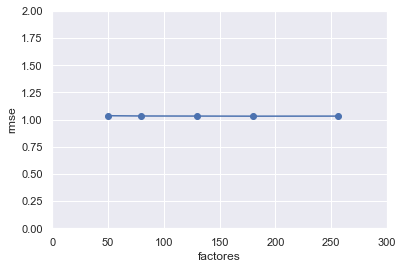

In [91]:
plt.plot(factores,rmse_test_means,'o-')
plt.ylim(0,2)
plt.xlim(0,300)
plt.xlabel("factores")
plt.ylabel("rmse")
plt.show()

In [94]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [100,150,200],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

Wall time: 27min 32s


In [95]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0319581645562526
{'n_factors': 150, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


El modelo benchmark, que uso una métrica de calificación, que combinaba el análisis de sentimientos de las reviews con la cantidad de horas tiene un RMSE de: 1.0638.

Mientras que el nuevo modelo, que usó una métrica de calificación exclusivamente basada en la cantidad de horas jugadas, tiene un RMSE de: 1.0247 con sus valores por defecto. Pude mejorar el modelo benchmark en un 3.6%.

La optimización de hiperperámetros no pudo mejorar el resultado del modelo con valores por defecto de los argumentos.
Esto seguramente se debe a la semilla que utiliza para hacer la división Train-Test.

Para mejorar aún más el modelo de sistema de recomendación, mi idea es incluir otros features de los videojuegos, cómo el género de videojuego y los diferentes tags que se le asginaron. Esto podría reducir aún más el error del modelo de recomendaciones.
Otro camino, es explorar con otros tipos de modelo de la librería ***surprise***, quizas tenga mejores resultados que el modelo ***SVD***.